# [Texture Generation with Multiple Neighborhood Neural Cellular Automata](https://distill.pub/selforg/2021/textures) (PyTorch version)

This Notebook is meant as an exploration of how to marry "Multiple Neighborhood Cellular Automata", MNCA, as pioneered by Slackermanz with "Neural Cellular Automata" by Alexander Mordvintsev, Ettore Randazzo, Eyvind Niklasson and Michael Levin. To find out more about MNCA read the following blog post by Slackermanz:

https://slackermanz.com/understanding-multiple-neighborhood-cellular-automata/

This notebook is entirely based on the following Notebook by Alexander Mordvintsev:

https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/texture_nca_pytorch.ipynb

The original notebook introduction and licence are as follows:

This notebook contains a minimalistic PyTorch implementation of the Texture Nerual CA model. For pretrained models and other experiments please refer to the [TF2 version](https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/texture_nca_tf2.ipynb).

*Copyright 2021 Google LLC*

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### Changelog

**2022-06-23**
  * Switched to sliced optmial transport VGG style loss
  * Fixed gradient checkpointing

In [ ]:
#@title Imports and Notebook Utilities
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, Markdown, clear_output
from tqdm import tqdm_notebook, tnrange

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    # wikimedia requires a user agent
    headers = {
      "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
    }
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg', id=None):
  return display(Image(data=imencode(a, fmt)), display_id=id)

def grab_plot(close=True):
  """Return the current Matplotlib figure as an image"""
  fig = pl.gcf()
  fig.canvas.draw()
  img = np.array(fig.canvas.renderer._renderer)
  a = np.float32(img[..., 3:]/255.0)
  img = np.uint8(255*(1.0-a) + img[...,:3] * a)  # alpha
  if close:
    pl.close()
  return img

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))


class LoopWriter(VideoWriter):
  def __init__(self, *a, cross_len=1.0, **kw):
    super().__init__(*a, **kw)
    self._intro = []
    self._outro = []
    self.cross_len = int(cross_len*self.params['fps'])

  def add(self, img):
    if len(self._intro) < self.cross_len:
      self._intro.append(img)
      return
    self._outro.append(img)
    if len(self._outro) > self.cross_len:
      super().add(self._outro.pop(0))

  def close(self):
    for t in np.linspace(0, 1, len(self._intro)):
      img = self._intro.pop(0)*t + self._outro.pop(0)*(1.0-t)
      super().add(img)
    super().close()

!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-01c9c087-6d95-b6ee-34d8-2ee164d9ccc5)


In [ ]:
import torch
import torchvision.models as models
import torch.nn.functional as F

torch.set_default_tensor_type('torch.cuda.FloatTensor')

!pip install git+https://github.com/pvigier/perlin-numpy
!pip install bitsandbytes
from perlin_numpy import generate_fractal_noise_2d
import bitsandbytes as bnb
import math

  Cloning https://github.com/pvigier/perlin-numpy to /tmp/pip-req-build-jr3zhrqe
  Running command git clone --filter=blob:none --quiet https://github.com/pvigier/perlin-numpy /tmp/pip-req-build-jr3zhrqe
  Resolved https://github.com/pvigier/perlin-numpy to commit 5e26837db14042e51166eb6cad4c0df2c1907016
  Preparing metadata (setup.py) ... done
  Created wheel for perlin-numpy: filename=perlin_numpy-0.0.0-py3-none-any.whl size=4719 sha256=300a4777c554ced2ddb23d776030cb6c5fc67d15371738402f6d06b3cea4b61c
  Stored in directory: /tmp/pip-ephem-wheel-cache-3sor3t2t/wheels/d0/67/1b/569e9d602b147a53e4ab67a3592944572d7d3886dc3a2e095e
Successfully built perlin-numpy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 11.2 MB/s eta 0:00:00


In [ ]:
#@title VGG16 Sliced OT Style Model
vgg16 = models.vgg16(weights='IMAGENET1K_V1').features

def calc_styles_vgg(imgs):
  style_layers = [1, 6, 11, 18, 25]
  mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None]
  std = torch.tensor([0.229, 0.224, 0.225])[:,None,None]
  x = (imgs-mean) / std
  b, c, h, w = x.shape
  features = [x.reshape(b, c, h*w)]
  for i, layer in enumerate(vgg16[:max(style_layers)+1]):
    x = layer(x)
    if i in style_layers:
      b, c, h, w = x.shape
      features.append(x.reshape(b, c, h*w))
  return features

def project_sort(x, proj):
  return torch.einsum('bcn,cp->bpn', x, proj).sort()[0]

def ot_loss(source, target, proj_n=32):
  ch, n = source.shape[-2:]
  projs = F.normalize(torch.randn(ch, proj_n), dim=0)
  source_proj = project_sort(source, projs)
  target_proj = project_sort(target, projs)
  target_interp = F.interpolate(target_proj, n, mode='nearest')
  return (source_proj-target_interp).square().sum()

def create_vgg_loss(target_img):
  yy = calc_styles_vgg(target_img)
  def loss_f(imgs):
    xx = calc_styles_vgg(imgs)
    return sum(ot_loss(x, y) for x, y in zip(xx, yy))
  return loss_f

def to_nchw(img):
  img = torch.as_tensor(img)
  if len(img.shape) == 3:
    img = img[None,...]
  return img.permute(0, 3, 1, 2)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 88.6MB/s]


In [ ]:
#@title Minimalistic Neural CA
ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

def perchannel_conv(x, filters):
  '''filters: [filter_n, h, w]'''
  b, ch, h, w = x.shape
  y = x.reshape(b*ch, 1, h, w)
  y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
  y = torch.nn.functional.conv2d(y, filters[:,None])
  return y.reshape(b, -1, h, w)

def perception(x):
  filters = torch.stack([ident, sobel_x, sobel_x.T, lap])
  return perchannel_conv(x, filters)

class CA(torch.nn.Module):
  def __init__(self, chn=12, hidden_n=96, start_scale = 0, perlin = True):
    super().__init__()
    self.chn = chn
    self.perlin = perlin
    self.w1 = torch.nn.Conv2d(chn*4, hidden_n, 1)
    self.w2 = torch.nn.Conv2d(hidden_n, chn, 1, bias=False)
    self.w2.weight.data = self.w2.weight.data*start_scale

  def forward(self, x):
    y = perception(x)
    y = self.w2(torch.relu(self.w1(y)))
    return x+y

  def seed(self, n, sz=256):
    if self.perlin:
      noise = torch.zeros(n, self.chn, sz, sz)
      for i in range(n):
        for j in range(self.chn):
          perlin_noise = torch.tensor(generate_fractal_noise_2d((sz, sz), (4, 4), 2, tileable=(True, True)))
          perlin_noise = (perlin_noise - perlin_noise.min()) / (perlin_noise.max() - perlin_noise.min()) - 0.5
          noise[i, j] = perlin_noise
      return noise
    else:
      return torch.rand(n, self.chn, sz, sz)-0.5

class MNCA(torch.nn.Module):
  def __init__(self, kernel_sizes = (3, 7), chn=12, hidden_n=46, update = 'sum', start_scale = 0, perlin = True, sig_scale = 1):
    super().__init__()
    self.kernel_sizes = kernel_sizes
    self.chn = chn
    self.update = update
    self.perlin = perlin
    self.sig_scale = sig_scale

    for k in kernel_sizes:
      self.add_module('in_'+str(k), torch.nn.Conv2d(chn, hidden_n, k, padding=k//2, padding_mode='circular'))
      self.add_module('w1_'+str(k), torch.nn.Conv2d(hidden_n, hidden_n, 1))
      self.add_module('w2_'+str(k), torch.nn.Conv2d(hidden_n, chn, 1, bias=False))
      self.__getattr__('w2_'+str(k)).weight.data = self.__getattr__('w2_'+str(k)).weight.data*start_scale

  def forward(self, x):
    b, c, h, w = x.shape
    y_out = []
    for k in self.kernel_sizes:
      y = self.__getattr__('in_'+str(k))(x)
      y = self.__getattr__('w2_'+str(k))(torch.relu(self.__getattr__('w1_'+str(k))(y)))
      y_out.append(y)

    if self.update == 'sum':
      y = sum(y_out)
    if self.update == 'rand':
      choice_mask = (torch.rand(b, len(y_out), h, w)+0.5).floor()
      choice_mask = torch.softmax(choice_mask*self.sig_scale, dim=1)
      y = sum([y_out[i]*choice_mask[:,i:i+1,:,:] for i in range(len(y_out))])
    if self.update == 'cons_x':
      if len(y_out) == 2:
        choice_mask = torch.sigmoid(x[:,3:4,:,:]*self.sig_scale)
        y = y_out[0]*choice_mask + y_out[1]*(1-choice_mask)
      else:
        choice_mask = x[:,3:(3+len(y_out)),:,:]
        choice_mask = torch.softmax(choice_mask*self.sig_scale, dim=1)
        y = sum([y_out[i]*choice_mask[:,i:i+1,:,:] for i in range(len(y_out))])
    if self.update == 'cons_y':
      if len(y_out) == 2:
        choice_mask = torch.sigmoid((y_out[0][:,3:4,:,:]+y_out[1][:,3:4,:,:])*self.sig_scale)
        y = y_out[0]*choice_mask + y_out[1]*(1-choice_mask)
      else:
        choice_mask = y_out[0][:,3:(3+len(y_out)),:,:]
        for i in range(1, len(y_out)):
          choice_mask += y_out[i][:,3:(3+len(y_out)),:,:]
        choice_mask = torch.softmax(choice_mask*self.sig_scale, dim=1)
        y = sum([y_out[i]*choice_mask[:,i:i+1,:,:] for i in range(len(y_out))])
    return x+y

  def seed(self, n, sz=256):
    if self.perlin:
      noise = torch.zeros(n, self.chn, sz, sz)
      for i in range(n):
        for j in range(self.chn):
          perlin_noise = torch.tensor(generate_fractal_noise_2d((sz, sz), (4, 4), 2, tileable=(True, True)))
          perlin_noise = (perlin_noise - perlin_noise.min()) / (perlin_noise.max() - perlin_noise.min()) - 0.5
          noise[i, j] = perlin_noise
      return noise
    else:
      return torch.rand(n, self.chn, sz, sz)-0.5

def to_rgb(x):
  return x[...,:3,:,:]+0.5

param_n = sum(p.numel() for p in MNCA().parameters())
print('CA param count:', param_n)

CA param count: 37536


## Parameters of the CA:
**model_type:** "multi" for multiple neighborhoods as adapted from Slackermanz, "base" is for the classic automata, by Alex Mordvintsev and friends.

**kernel_sizes:** A tuple that determines the neighborhood sizes.

**start_scale_test:** the scaling of the initial weights of the final convolutional layer of the CA for the inductive bias test, lower if the dynamics of the system explode.

**start_scale_train:** the scaling of the initial weights of the final convolutional layer of the CA for the training (Alex Mordvintsev used 0 but small, non-0 values might train faster).

**Perlin:** if True, the initial state of the CA is generated by Perlin/fractal noise, if False, it is generated by random uniform noise.

**update:** determines how it is decided which of the two update rules is used. In "sum", both are summed, in "rand", one is chosen randomly for each pixel, in "cons_x" the choice is based on a hidden channel of the input, in "cons_y" the choice is based on a hidden channel of the output of both update rules.

**sig_scale:** the scaling of the sigmoid function in "cons_x" and "cons_y".

**hidden_n:** the number of hidden units in the CNN.

**chn:** the number of channels of the CA.

**gradient_checkpoints:** if True, the gradient checkpoints are used, which lowers the memory requirements, but increases the computation time.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_type = 'multi' #@param ["multi", "base"]
kernel_sizes = (3, 7) #@param {type:"raw"}
start_scale_test = 0.2 #@param {type:"number"}
start_scale_train = 0.01 #@param {type:"number"}
perlin = True #@param {type:"boolean"}
update = 'cons_x' #@param ["sum", "rand", "cons_x", "cons_y"]
sig_scale = 1 #@param {type:"number"}
hidden_n = 46 #@param {type:"number"}
chn = 12 #@param {type:"number"}
gradient_checkpoints = True #@param {type:"boolean"}

In [ ]:
#@title NCA-untrained video for inductive bias study {vertical-output: true}
if model_type == 'multi':
  ca = MNCA(kernel_sizes = kernel_sizes, chn=chn, hidden_n=hidden_n, start_scale=start_scale_test, perlin=perlin, update=update, sig_scale=sig_scale)
elif model_type == 'base':
  ca = CA(chn=chn, hidden_n=hidden_n, start_scale=start_scale_test, perlin=perlin)

with VideoWriter() as vid, torch.no_grad():
  x = ca.seed(1, 256)
  for k in tnrange(300, leave=False):
    step_n = 2
    for i in range(step_n):
      x[:] = ca(x)
    img = to_rgb(x[0]).permute(1, 2, 0).cpu()
    vid.add(zoom(img, 2))

  for k in tnrange(300, leave=False):



  0%|          | 0/300 [00:00<?, ?it/s]

## Training with Texture loss

  img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)



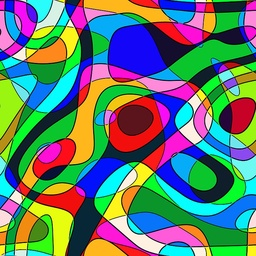

In [ ]:
#@title Target image {vertical-output: true}
url = 'https://i0.hippopx.com/photos/521/378/436/digital-multicolor-colorful-curves-preview.jpg'
style_img = imread(url, max_size=256)[:, :, 0:3]
with torch.no_grad():
  loss_f = create_vgg_loss(to_nchw(style_img))
imshow(style_img)

In [ ]:
#@title setup training
if model_type == 'multi':
  ca = MNCA(kernel_sizes = kernel_sizes, chn=chn, hidden_n=hidden_n, start_scale=start_scale_train, perlin=perlin, update=update, sig_scale=sig_scale)
elif model_type == 'base':
  ca = CA(chn=chn, hidden_n=hidden_n, start_scale=start_scale_train, perlin=perlin)

opt = torch.optim.Adam(ca.parameters(), 1e-3, capturable=True)
#opt = bnb.optim.Adam(ca.parameters(), 1e-3)
scaler = torch.cuda.amp.GradScaler()
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [1000, 2000], 0.3)
loss_log = []
with torch.no_grad():
  pool = ca.seed(256)


        step_n: 856
        loss: 6256391.5
        lr: 0.001

  pl.ylim(np.min(loss_log), loss_log[0])



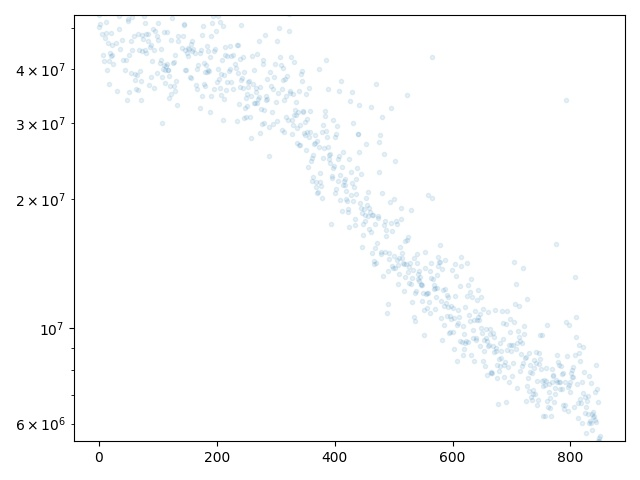

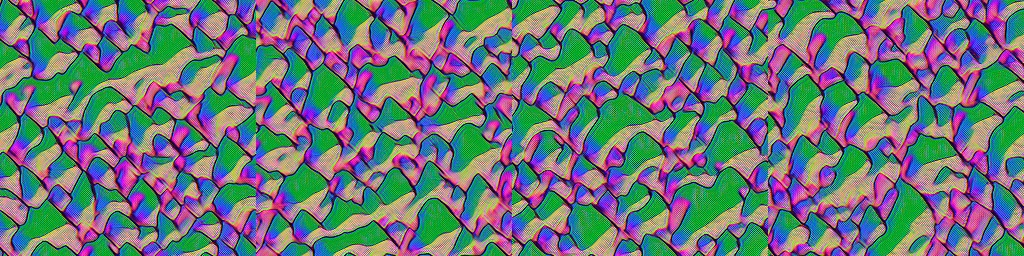

In [ ]:
#@title training loop (original) {vertical-output: true}

for i in range(5000):
  with torch.no_grad():
    batch_idx = np.random.choice(len(pool), 4, replace=False)
    x = pool[batch_idx]
    if i%8 == 0:
      x[:1] = ca.seed(1)
  step_n = np.random.randint(32, 96)
  if not gradient_checkpoints:
    for k in range(step_n):
      x = ca(x)
  else:
    x.requires_grad = True  # https://github.com/pytorch/pytorch/issues/42812
    x = torch.utils.checkpoint.checkpoint_sequential([ca]*step_n, 16, x)

  overflow_loss = (x-x.clamp(-1.0, 1.0)).abs().sum()
  loss = loss_f(to_rgb(x))+overflow_loss
  with torch.no_grad():
    loss.backward()
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool[batch_idx] = x                # update pool

    loss_log.append(loss.item())
    if i%5 == 0:
      display(Markdown(f'''
        step_n: {len(loss_log)}
        loss: {loss.item()}
        lr: {lr_sched.get_last_lr()[0]}'''), display_id='stats')
    if i%50==0:
      pl.plot(loss_log, '.', alpha=0.1)
      pl.yscale('log')
      pl.ylim(np.min(loss_log), loss_log[0])
      pl.tight_layout()
      imshow(grab_plot(), id='log')
      imgs = to_rgb(x).permute([0, 2, 3, 1]).cpu()
      imshow(np.hstack(imgs), id='batch')

In [ ]:
#@title NCA video {vertical-output: true}
with VideoWriter() as vid, torch.no_grad():
  x = ca.seed(1, 512)
  for k in tnrange(300, leave=False):
    step_n = 3
    for i in range(step_n):
      x[:] = ca(x)
    img = to_rgb(x[0]).permute(1, 2, 0).cpu()
    vid.add(zoom(img, 1))